Use Occupation Kernels to learn the Duffing Oscillator, a non-linear dynamical system given by the following equation:
$$
\begin{bmatrix}
\ddot{x}(t) \\
\dot{x}(t)\\
\end{bmatrix} = \begin{bmatrix}
\dot{x}(t) \\
x(t)(1 - x(t)^2) \\
\end{bmatrix}$$

This is a Pytorch implementation (with a slight extension to Gaussian processes) of an approach presented in this video and corresponding paper: 

https://www.youtube.com/watch?v=lWuOUOJS_qw

X. Li and J. A. Rosenfeld, "Fractional Order System Identification With Occupation Kernel Regression," in IEEE Control Systems Letters, vol. 6, pp. 19-24, 2022, doi: 10.1109/LCSYS.2020.3046408.

A trajectory maps $\gamma_i: [0, T] \to \mathbb{R}^n$
$$\dot{\gamma}_i(t) = F(\gamma_i(t))$$
where:
$$F: \mathbb{R}^n \to \mathbb{R}^n $$
$$f_j: \mathbb{R}^n \to \mathbb{R}$$
where $F = [f_1, ... f_n]$

For the Duffing Oscillator, we have $n=2$, $f_1(x, \dot{x}) = \dot{x}$ and $f_2(x, \dot{x}) = x(1-x^2)$

We create a reproducing kernel Hilbert space (RKHS) $\mathcal{H}$ of functions $g: \mathbb{R}^n \to \mathbb{R}$

We can define the following linear functional in this space $G_{\gamma_i}: \mathcal{H} \to \mathbb{R}$

$$ G_{\gamma_i}(g) = \int^T_0 g(\gamma_i(t)) dt $$

Note $$G_{\gamma_i}(f_j) = \int^T_0 f_j(\gamma_i(t)) dt = \int^T_0 [\dot{\gamma_i}(t)]_j dt = [\gamma_i(T) - \gamma_i(0)]_j$$

By Riesz's representation theorem, we can represent this linear functional as the inner product with some vector $\Gamma_{\gamma_i} \in \mathcal{H}$ $$G_{\gamma_i}(g) = <g, \Gamma_{\gamma_i}>$$

Since we have an RKHS, we have the kernel with the reproducing property $k: \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R}$. We can use this to evaluate $\Gamma_{\gamma_i}$.
\begin{align*}
\Gamma_{\gamma_i}(\mathbf{x}) &= <\Gamma_{\gamma_i}, k(\cdot, \mathbf{x})> \\
&= G_{\gamma_i}(k(\cdot, \mathbf{x})) \\
&= \int^T_0 k(\gamma_i(t), \mathbf{x}) dt
\end{align*}

We can also use the kernel to evaluate the inner product of two $\Gamma$ functions.

\begin{align*}
<\Gamma_{\gamma_i}, \Gamma_{\gamma_j}> &= G_{\gamma_j}(\Gamma_{\gamma_i}) \\
(\text{def $G$}) \implies &= \int^T_0 \Gamma_{\gamma_i}(\gamma_j(t)) dt \\
(\text{def $\Gamma_{\gamma_i}$}) \implies&= \int^T_0 \int^T_0 k(\gamma_i(t'), \gamma_j(t)) dt dt'
\end{align*}

We will fit two Gaussian Process models to $f_1$ and $f_2$ independently, and optimise the kernel hyperparameters against the negative log likelihood.

In [1]:
from typing import Callable
import numpy as np
from scipy import integrate
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [2]:
ORDER = 2
H = 0.01
TRAJ_LEN = 101

IvpFunction = Callable[[float, np.ndarray], np.ndarray]

First, we generate trajectories from the differential equation

In [3]:
def duffing(_t: float, y: np.ndarray) -> np.ndarray:
    assert y.shape[-1] == ORDER
    return np.array([y[..., 1], y[..., 0] * (1.0 - y[..., 0] * y[..., 0])])


def generate_trajectory(y_0: np.ndarray, f: IvpFunction) -> np.ndarray:
    t_0 = 0.0
    t_max = H * TRAJ_LEN
    odesolve = integrate.solve_ivp(
        f, t_span=(t_0, t_max), y0=y_0, max_step=H, t_eval=np.arange(t_0, t_max, H)
    )
    return odesolve.y


def generate_trajectories() -> np.ndarray:
    lin = np.arange(-3.0, 3.1, 0.5)
    y_0, y_dot_0 = np.meshgrid(lin, lin)

    y_0 = y_0.reshape((-1, 1))
    y_dot_0 = y_dot_0.reshape((-1, 1))
    y_0s = np.hstack([y_0, y_dot_0])

    return np.array([generate_trajectory(y_0, duffing) for y_0 in y_0s])

In [4]:
trajectories = torch.Tensor(generate_trajectories())
num_trajectories = trajectories.shape[0]  # m

Text(0.5, 1.0, 'Phase Space Trajectory plot')

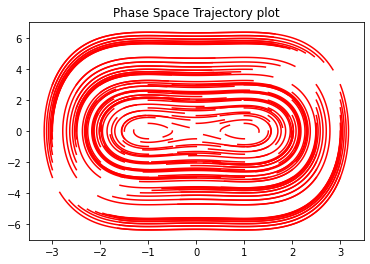

In [5]:
for trajectory in trajectories:
    plt.plot(trajectory[0, ...], trajectory[1, ...], 'r')
plt.title("Phase Space Trajectory plot")

We now approximate $f_j: \mathbb{R}^n \to \mathbb{R}$ by

$$ f^*_j(\mathbf{x}) = \Gamma_{\gamma}(\mathbf{x})^\top \mathbf{w}_j$$

for $m$ observed trajectories $\gamma(t) = [\gamma_1(t), ... \gamma_m(t)]$

We put a Gaussian prior on $\mathbf{w}_j$

$$ p(\mathbf{w}_j) = \mathcal{N}(\mathbf{0}, \Sigma) $$

And likelihood function:

$$ p(f_j | \mathbf{x}, \mathbf{w}_j) = \mathcal{N}(\Gamma_{\gamma}(\mathbf{x})^\top \mathbf{w}_j, \sigma^2_n) $$

Then the posterior is:
 $$ p(\mathbf{w}_j | \mathbf{x}, f_j) = \mathcal{N} (A^{-1}\mathbf{b}_j, \sigma^2_n A^{-1}) $$
 where
 \begin{align*}
G & = <\Gamma_i, \Gamma_j> \\
A &= G + \sigma^2_n\Sigma^{-1} \\
b_j &= [\gamma(T) - \gamma(0)]_j
 \end{align*}

where we have used that $<f_j, \Gamma_\gamma(\mathbf{x})> = G_\gamma(f_j)$
And the posterior predicted points are given by:
$$p(f_j^* | \mathbf{x}^*, \mathbf{x}, f_j) = \mathcal{N}(\Gamma_\gamma(\mathbf{x}^*)^\top A^{-1} b_j, \sigma^2_n \Gamma_\gamma(\mathbf{x}^*)^\top A^{-1} \Gamma_\gamma(\mathbf{x}^*)) $$


Create the model that will contain the kernel hyperparameters that we want to learn.

Use a simple linear kernel for the first dimension:

$$k_0(x, x') = x^\top \eta_0 x'$$

For the second dimension we use:

$$k_1(x, x') = x^\top \eta_1 x' + (x^\top \alpha_1 x')^3 + e^{(x - x')^\top \mu_1 (x - x')}$$

These choices are clearly quite specific for the particular dynamical system, but a fit with just the squared exponential does quite well, at which point you can see that the latent functions are approximately linear and cubic, and can modify the choice of kernel accordingly.

We parameterise the matrices with their diagonal elements and pass them through a softplus to ensure they always remain positive.

The `occupation_vector` function allows you to evaluate:
$$\Gamma_{\gamma_i}(\mathbf{x}) = \int^T_0 k(\gamma_i(t), \mathbf{x})$$
And (by applying it twice):

$$<\Gamma_{\gamma_i}, \Gamma_{\gamma_j}> = \int^T_0 \int^T_0 k(\gamma_i(t'), \gamma_j(t)) dt dt'$$

In [6]:
class Model:
    def __init__(self):
        """Create the parameters to be optimised"""
        self.softplus = torch.nn.Softplus()
        # parameters of the first dimension kernel
        self.eta0_diag = torch.tensor(
            [-11.7333, -2.9627], requires_grad=True, dtype=torch.float
        )
        # parameters of the second dimension kernel
        self.mu1_diag = torch.tensor(
            [-5.8825, -8.8072], requires_grad=True, dtype=torch.float
        )
        self.eta1_diag = torch.tensor(
            [-0.4519, -8.6607], requires_grad=True, dtype=torch.float
        )
        self.alpha1_diag = torch.tensor(
            [-0.5680, -7.3469], requires_grad=True, dtype=torch.float
        )

        self.params = [
            self.eta0_diag,
            self.mu1_diag,
            self.eta1_diag,
            self.alpha1_diag,
        ]

        self.optimizer = torch.optim.Adam(self.params, lr=1e-2)

    def occupation_vector(
        self, x: torch.Tensor, trajectories: torch.Tensor
    ) -> torch.Tensor:
        """Calculate Γ_γ(x) for each γ in the trajectories

        x must be of shape [dim, dim_trajectory, len_trajectory]
        trajectories is of shape [num_trajectories, dim_trajectory, len_train_trajectory]

        will return something of shape [dim_trajectory, num_trajectories, dim, len_trajectory]
        """

        # kernel for the first dimension (linear)
        eta0 = torch.diagflat(self.softplus(self.eta0_diag))
        # [num_trajectories, dim, len_trajectory, len_train_trajectory]
        k = torch.einsum("ijk,jl,nlm->inmk", trajectories, eta0, x)

        # [num_trajectories, dim, len_trajectory]
        y_0 = integrate_simpson(k, dx=H)

        # kernel for the second dimension (linear + squared exp + cubic)
        mu1 = torch.diagflat(self.softplus(self.mu1_diag))
        eta1 = torch.diagflat(self.softplus(self.eta1_diag))
        alpha1 = torch.diagflat(self.softplus(self.alpha1_diag))

        # linear kernel
        # [num_trajectories, dim, len_trajectory, len_train_trajectory]
        k = torch.einsum("ijk,jl,nlm->inmk", trajectories, eta1, x)

        # squared exponential kernel
        # [num_trajectories, dim, dim_trajectory, len_trajectory, len_train_trajectory]
        diff = x[None, ..., None] - trajectories[:, None, :, None, :]
        # [num_trajectories, dim, len_trajectory, len_train_trajectory]
        k2 = torch.exp(-torch.einsum("...ijk,il,...ljk->...jk", diff, mu1, diff))

        # cubic kernel
        k3 = torch.einsum("ijk,jl,nlm->inmk", trajectories, alpha1, x)
        # [num_trajectories, dim, len_trajectory]
        y_1 = integrate_simpson(k + k2 + k3 * k3 * k3, dx=H)

        # [dim_trajectory, num_trajectories, dim, len_trajectory]
        return torch.stack([y_0, y_1], axis=0)

In [7]:
def integrate_simpson(x: torch.Tensor, dx: float) -> torch.Tensor:
    """Perform numerical integration using Simpson's rule, requires an odd number of samples
    
    There is no inbuilt Torch version of this

    Integrates over the last axis so x [..., dim] -> [...]
    """
    len_traj = x.shape[-1]

    assert len_traj % 2 == 1, "Must have odd length trajectories"

    # https://en.wikipedia.org/wiki/Simpson%27s_rule#Composite_Simpson's_rule
    # [1, 4, 2, 4, 2, 4, ... 1]
    simpsons_vector = torch.Tensor([1, *([4, 2] * ((len_traj - 3) // 2)), 4, 1])
    return x @ simpsons_vector * dx / 3

We create an optimisation loop for the above model, the log likelihood is given by:

$$ \log(p(f_j|\mathbf{x})) = - \frac{1}{2}(\mathbf{b}^\top A^{-1} \mathbf{b} + \log(|A|) + m\log(2\pi) )$$

In [8]:
# observation noise σₙ²
sigma2_inv = 1e-3

model = Model()
# Σ the covariance matrix of the prior on w, i.e. w ~ 𝓝(0, Σ)
# [1, num_trajectories, num_trajectories]
weight_prior_cov = torch.eye(num_trajectories)[None, ...]

# how many optimisation steps to perform, has to run at least once to create all the tensors
opt_steps = 1
# optimization loop
for i in range(opt_steps):
    # create the gram matrix
    # estimate G = <Γ_γⱼ, Γ_γᵢ> = ∫₀ᵀ∫₀ᵀ K(γᵢ(t'), γⱼ(t)) dt dt'
    # [dim_trajectory, num_trajectories, num_trajectories]
    gram = integrate_simpson(
        model.occupation_vector(trajectories, trajectories), dx=H
    )
    # [dim_trajectory, num_trajectories, num_trajectories] chol(A) = chol(G + σₙ²Σ⁻¹)
    chol = torch.linalg.cholesky(gram + sigma2_inv * weight_prior_cov)

    # [num_trajectories, dim_trajectory] b = γ(T) - γ(0)
    eval_matrix = trajectories[:, :, -1] - trajectories[:, :, 0]
    # [dim_trajectory, num_trajectories] posterior mean of the weights A⁻¹b
    weights = torch.cholesky_solve(eval_matrix.t()[..., None], chol)[..., 0]
    # scalar - negative log likelihood ½ (bᵀA⁻¹b + log|A| + m log 2π)
    neg_log_lik = 0.5 * (
        torch.sum(weights * weights)
        # determinant of a cholesky is the product of the diagonal, square for stability
        + torch.sum(torch.log(torch.square(torch.diagonal(chol, dim1=-2, dim2=-1))))
        + num_trajectories * np.log(2 * np.pi)
    )

    # do the backpropagation
    if opt_steps > 1:
        model.optimizer.zero_grad()
        neg_log_lik.backward()
        model.optimizer.step()

    print(i, model.params, neg_log_lik)

0 [tensor([-11.7333,  -2.9627], requires_grad=True), tensor([-5.8825, -8.8072], requires_grad=True), tensor([-0.4519, -8.6607], requires_grad=True), tensor([-0.5680, -7.3469], requires_grad=True)] tensor(-981.3876, grad_fn=<MulBackward0>)


We now plot the latent functions given by:

$$p(f_j^* | \mathbf{x}^*, \mathbf{x}, f_j) = \mathcal{N}(\Gamma_\gamma(\mathbf{x}^*)^\top A^{-1} b_j, \sigma^2_n \Gamma_\gamma(\mathbf{x}^*)^\top A^{-1} \Gamma_\gamma(\mathbf{x}^*)) $$

<IPython.core.display.Javascript object>


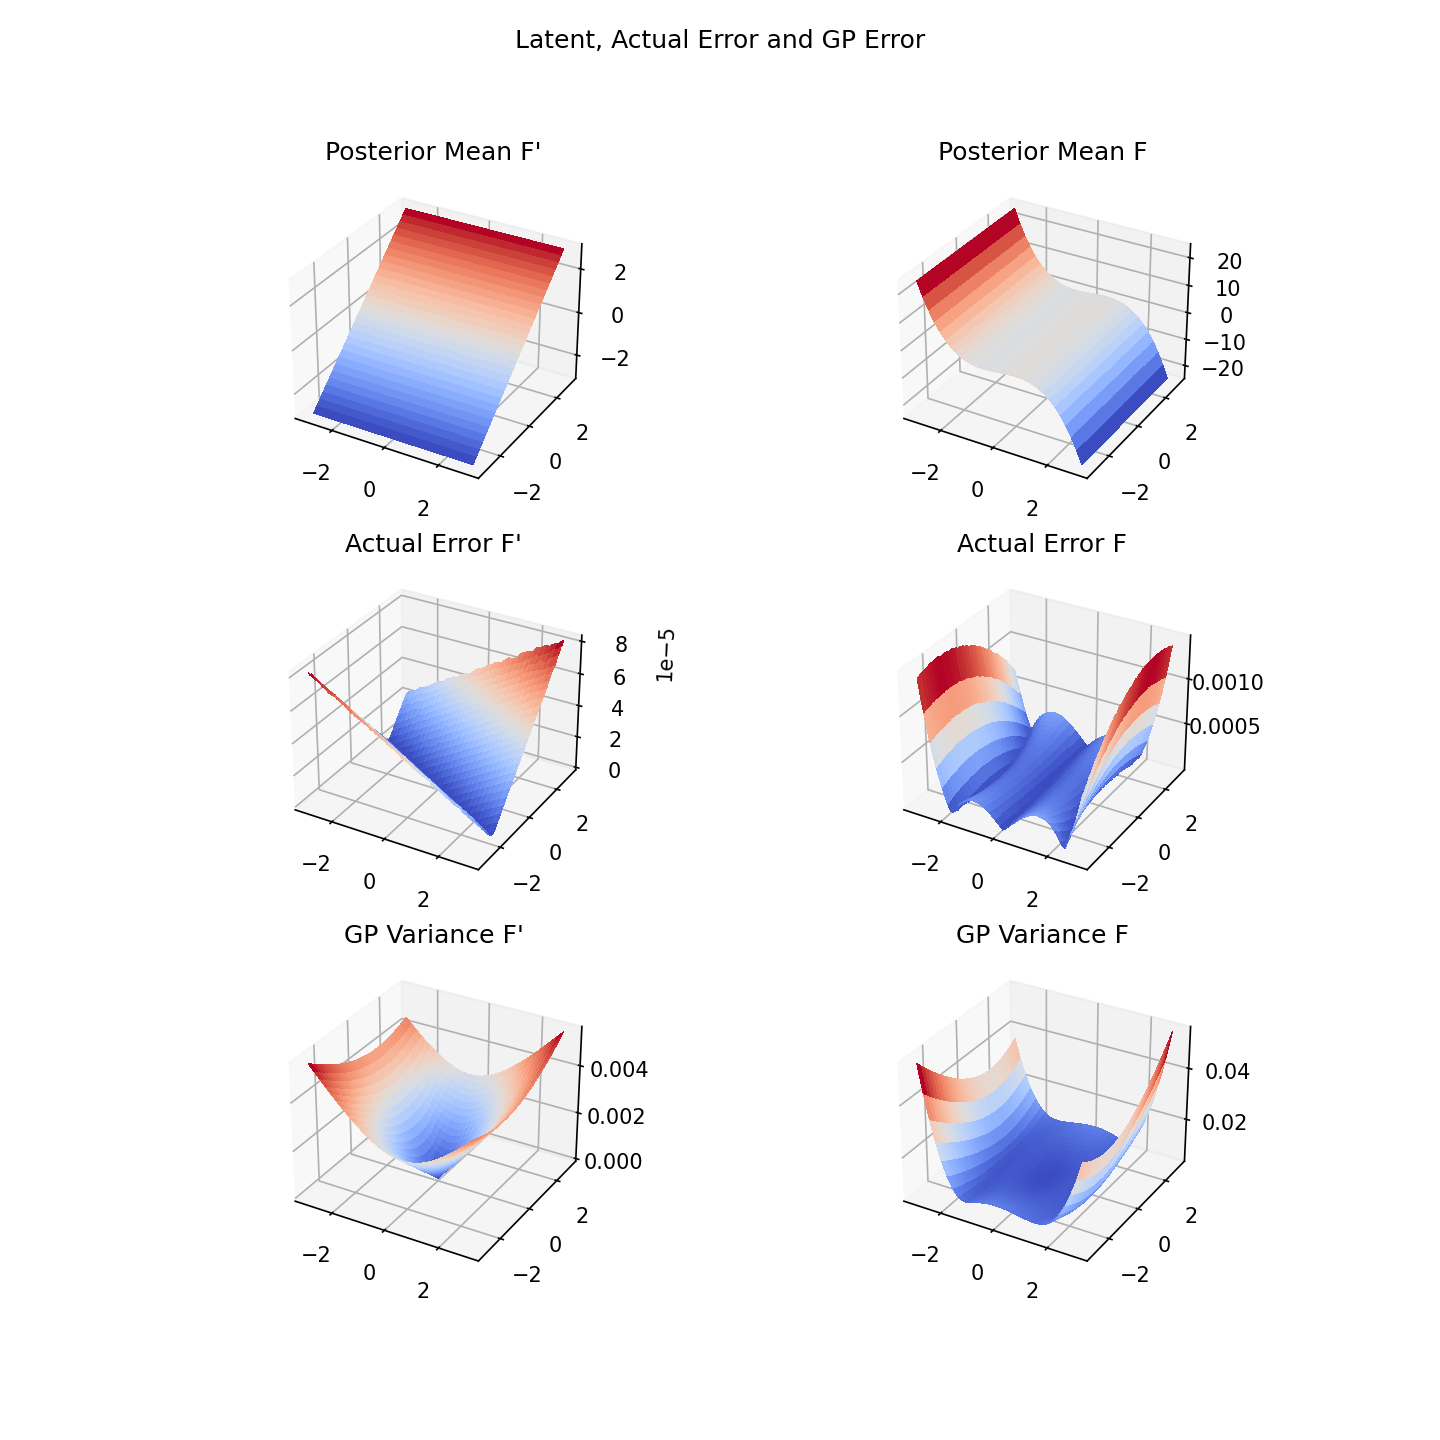

In [12]:
%matplotlib notebook
# [len]
lin = np.arange(-3.0, 3.1, 0.1)
# [len, len], [len, len]
y_0, y_dot_0 = np.meshgrid(lin, lin)

# [len, dim_trajectory, len]
y_0s = np.stack([y_0, y_dot_0], axis=1)

# [dim_trajectory, num_trajectories, len, len] Γ_γ(x*)
test_occ_vector = model.occupation_vector(torch.Tensor(y_0s), trajectories)
# [dim_trajectory, len, len] Γ_γ(x*)ᵀA⁻¹b = Γ_γ(x*)ᵀw
posterior_mean = (
    torch.einsum("ji,jikl->jkl", weights, test_occ_vector).detach().numpy()
)

# [dim_trajectory, len, num_trajectories, len] chol(A)⁻¹Γ_γ(x*)
chol_cov = torch.cholesky_solve(
    torch.swapaxes(test_occ_vector, 1, 2), chol[:, None, ...]
)
# [dim_trajectory, len, len] σₙ²(chol(A)⁻¹Γ_γ(x*))ᵀ(chol(A)⁻¹Γ_γ(x*))
posterior_cov = (
    torch.sum(chol_cov * chol_cov, axis=-2).detach().numpy() * sigma2_inv
)

# plot the surface
fig, ax = plt.subplots(ncols=2, nrows=3, subplot_kw={"projection": "3d"}, figsize=(9.6, 9.6))
fig.suptitle("Latent, Actual Error and GP Error")
def plot_surface(ax: plt.Axes, array: np.ndarray):
    ax.plot_surface(
        y_0,
        y_dot_0,
        array,
        cmap=cm.coolwarm,
        linewidth=0,
        antialiased=False,
    )

# [dim_trajectory, len, len]
actual_diffs = duffing(0, np.swapaxes(y_0s, 1, 2)) - posterior_mean
for i, title in enumerate(["F'", "F"]):
    plot_surface(ax[0, i], posterior_mean[i, ...])
    ax[0, i].set_title("Posterior Mean " + title)
    plot_surface(ax[1, i], np.abs(actual_diffs)[i, ...])
    ax[1, i].set_title("Actual Error " + title)
    plot_surface(ax[2, i], np.sqrt(posterior_cov[i, ...]))
    ax[2, i].set_title("GP Variance " + title)

Finally, we generate some trajectories from the learned latent functions and from the actual dynamical system and compare.

In [10]:
# create a function which queries the GP
def gp_duffing(_t: float, y: np.ndarray) -> np.ndarray:
    assert y.shape == (2,)
    # [dim_trajectory] Γ_γ(x*)
    test_occ_vector = model.occupation_vector(
        torch.Tensor(y[None, :, None]), trajectories
    )[..., 0, 0]
    # [dim_trajectory] Γ_γ(x*)ᵀA⁻¹b
    return torch.einsum("ij,ij->i", weights, test_occ_vector).detach().numpy()

We see that the generated trajectories align indistinguishably to the correct ones. We have picked trajectories that do not appear in the training set.

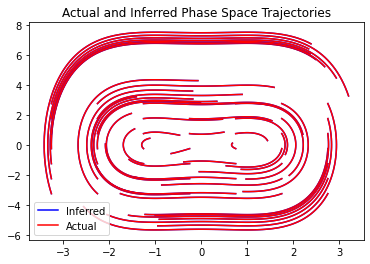

In [11]:
%matplotlib inline
"""Plot real and estimated trajectories from the Duffing Oscillator"""
# [len]
lin = np.arange(-3.25, 3, 1.0)
# [len, len], [len, len]
y_0, y_dot_0 = np.meshgrid(lin, lin)

# [len * len, 1]
y_0 = y_0.reshape((-1, 1))
# [len * len, 1]
y_dot_0 = y_dot_0.reshape((-1, 1))
# [len * len, 2]
y_0s = np.hstack([y_0, y_dot_0])

_, ax = plt.subplots()
ax.set_title("Actual and Inferred Phase Space Trajectories")
# generate more trajectories
for y_0 in y_0s:
    trajectory = np.array(generate_trajectory(y_0, gp_duffing))
    (inferred,) = ax.plot(
        trajectory[0, :], trajectory[1, :], c="b", label="Inferred"
    )
    trajectory = np.array(generate_trajectory(y_0, duffing))
    (actual,) = ax.plot(trajectory[0, :], trajectory[1, :], c="r", label="Actual")
ax.legend(handles=[inferred, actual])